In [1]:
# Implementation of the DRAW network from ArXiv 1502.04623
# With some inspiration from Eric Jang (https://blog.evjang.com/2016/06/understanding-and-implementing.html)
# Using with py27
# ADDING MEANINGFUL USE OF BATCHES

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
'''See: https://www.tensorflow.org/versions/r1.1/get_started/mnist/beginners'''
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm # color maps
from sklearn.manifold import TSNE
%matplotlib inline
tf.logging.set_verbosity(tf.logging.INFO)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


/Users/adammarblestone/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# Check for GPU
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

devices = get_available_devices()

print(devices)

[u'/device:CPU:0']


In [4]:
def MNIST_row_as_image(row):
    arr1 = []
    for i in range(28):
        arr2 = []
        for j in range(28):
            arr2.append(row[28*i + j])
        arr1.append(arr2)
    return np.array(arr1)

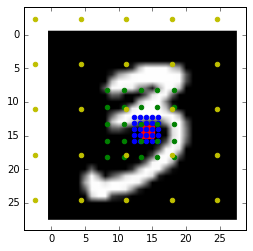

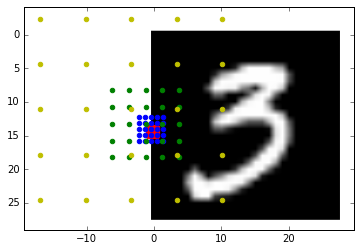

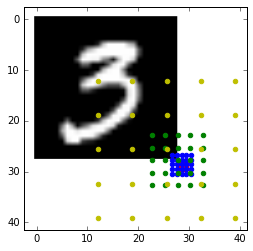

In [5]:
def tf_get_filter_banks(center_coords_dec, sigma_dec, stride_dec, N): # NxN grid of filters
    A,B = 28,28 # For MNIST
    sigma_dec = tf.exp(sigma_dec) # Note: sigma_decoded is the variance not the standard deviation here
    stride_dec = tf.exp(stride_dec) # These start as logs
    stride = stride_dec*float(A-1)/(N-1)
    cx = (center_coords_dec[0]+1)*(float(A+1)/2.0)
    cy = (center_coords_dec[1]+1)*(float(B+1)/2.0)
    center_coords = [cx, cy]
    
    means_of_filtersx = []
    means_of_filtersy = []
    normx = []
    normy = []
    epsilon = 0.0000001
    for i in range(N):
        x_mean = center_coords[0] + (i-N/2-0.5)*stride
        y_mean = center_coords[1] + (i-N/2-0.5)*stride
        means_of_filtersx.append(x_mean)
        means_of_filtersy.append(y_mean)
        normx.append(tf.maximum(tf.reduce_sum([tf.exp(-(ahat-means_of_filtersx[i])**2/(2*(sigma_dec))) for ahat in range(A)]), epsilon))
        normy.append(tf.maximum(tf.reduce_sum([tf.exp(-(bhat-means_of_filtersy[i])**2/(2*(sigma_dec))) for bhat in range(B)]), epsilon))
        
    filter_bank_X = [[(tf.exp(-(a-means_of_filtersx[i])**2/(2*(sigma_dec))))/normx[i] for a in range(A)] for i in range(N)]
    filter_bank_Y = [[(tf.exp(-(b-means_of_filtersy[i])**2/(2*(sigma_dec))))/normy[i] for b in range(B)] for i in range(N)]
    
    return filter_bank_X, filter_bank_Y

def np_get_filter_banks(center_coords_dec, sigma_dec, stride_dec, N): # NxN grid of filters
    A,B = 28,28 # For MNIST
    sigma_dec = np.exp(sigma_dec) # Note: sigma_decoded is the variance not the standard deviation here
    stride_dec = np.exp(stride_dec) # These start as logs
    stride = stride_dec*(float(A-1))/(N-1) 
    cx = (center_coords_dec[0]+1)*(float(A+1)/2.0)
    cy = (center_coords_dec[1]+1)*(float(B+1)/2.0)
    center_coords = [cx, cy]
    
    means_of_filtersx = []
    means_of_filtersy = []
    normx = []
    normy = []
    epsilon = 0.0000001
    for i in range(N):
        x_mean = center_coords[0] + (i-N/2-0.5)*stride
        y_mean = center_coords[1] + (i-N/2-0.5)*stride
        means_of_filtersx.append(x_mean)
        means_of_filtersy.append(y_mean)
        normx.append(np.max([np.sum([np.exp(-(ahat-means_of_filtersx[i])**2/(2*(sigma_dec))) for ahat in range(A)]), epsilon]))
        normy.append(np.max([np.sum([np.exp(-(bhat-means_of_filtersy[i])**2/(2*(sigma_dec))) for bhat in range(B)]), epsilon]))
        
    filter_bank_X = [[(np.exp(-(a-means_of_filtersx[i])**2/(2*(sigma_dec))))/normx[i] for a in range(A)] for i in range(N)]
    filter_bank_Y = [[(np.exp(-(b-means_of_filtersy[i])**2/(2*(sigma_dec))))/normy[i] for b in range(B)] for i in range(N)]
    
    return filter_bank_X, filter_bank_Y, [[x,y] for x in means_of_filtersx for y in means_of_filtersy]

# Test the placement
img = mnist.train.images[10003][:]
plt.figure()
plt.imshow(MNIST_row_as_image(img), cmap = cm.Greys_r)
_, _, means = np_get_filter_banks(center_coords_dec = [0,0], sigma_dec = 0, stride_dec = -3, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'r')
_, _, means = np_get_filter_banks(center_coords_dec = [0,0], sigma_dec = 0, stride_dec = -2, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'b')
_, _, means = np_get_filter_banks(center_coords_dec = [0,0], sigma_dec = 0, stride_dec = -1, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'g')
_, _, means = np_get_filter_banks(center_coords_dec = [0,0], sigma_dec = 0, stride_dec = -0, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'y')
plt.figure()
plt.imshow(MNIST_row_as_image(img), cmap = cm.Greys_r)
_, _, means = np_get_filter_banks(center_coords_dec = [-1,0], sigma_dec = 0, stride_dec = -3, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'r')
_, _, means = np_get_filter_banks(center_coords_dec = [-1,0], sigma_dec = 0, stride_dec = -2, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'b')
_, _, means = np_get_filter_banks(center_coords_dec = [-1,0], sigma_dec = 0, stride_dec = -1, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'g')
_, _, means = np_get_filter_banks(center_coords_dec = [-1,0], sigma_dec = 0, stride_dec = -0, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'y')
plt.show()
plt.figure()
plt.imshow(MNIST_row_as_image(img), cmap = cm.Greys_r)
_, _, means = np_get_filter_banks(center_coords_dec = [1,1], sigma_dec = 0, stride_dec = -3, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'r')
_, _, means = np_get_filter_banks(center_coords_dec = [1,1], sigma_dec = 0, stride_dec = -2, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'b')
_, _, means = np_get_filter_banks(center_coords_dec = [1,1], sigma_dec = 0, stride_dec = -1, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'g')
_, _, means = np_get_filter_banks(center_coords_dec = [1,1], sigma_dec = 0, stride_dec = -0, N = 5)
scat = plt.scatter([m[0] for m in means], [m[1] for m in means], color = 'y')

In [6]:
# With some inspiration from Eric Jang: https://blog.evjang.com/2016/06/understanding-and-implementing.html
attention = False
variational = True
num_time_steps = 3
num_units_enc = 2
num_units_dec = 2
num_latents = 2
N_read = 5
N_write = 5
A = 28
B = 28

batch_size = 4

DO_SHARE = False

# Recorded variables

canvas = [None] * num_time_steps
center_coords_decoded = [None] * num_time_steps
sigma_decoded = [None] * num_time_steps
stride_decoded = [None] * num_time_steps
gamma_decoded = [None] * num_time_steps
center_coords_decoded_write = [None] * num_time_steps
sigma_decoded_write = [None] * num_time_steps
stride_decoded_write = [None] * num_time_steps
gamma_decoded_write = [None] * num_time_steps
lms = [None] * num_time_steps
lss = [None] * num_time_steps

# Setting up the computational graph

x = tf.placeholder(shape=[batch_size, A*B],dtype=tf.float32, name = 'x')
canvas_previous = tf.zeros(shape=[batch_size, A*B])

encoder_cell = tf.contrib.rnn.LSTMBlockCell(num_units = num_units_enc)
encoder_state_previous = encoder_cell.zero_state(batch_size, tf.float32)
def encode_step(input_data, network_state):
    with tf.variable_scope("encoder",reuse=DO_SHARE):
        return encoder_cell(inputs = input_data, state = network_state) # This does one cycle of the RNN
        # This uses the __call__ method

decoder_cell = tf.contrib.rnn.LSTMBlockCell(num_units = num_units_dec)
decoder_state_previous = decoder_cell.zero_state(batch_size, tf.float32)
def decode_step(latents, network_state):
    with tf.variable_scope("decoder",reuse=DO_SHARE):
        return decoder_cell(inputs = latents, state = network_state) # This does one cycle of the RNN
        # This uses the __call__ method
    
for t in range(num_time_steps): # Replace with tf.while_loop
    print ("Setting up graph for time-step %i" %t)

    xhat = x-tf.sigmoid(canvas_previous)

    if attention:
        with tf.variable_scope("read_operation",reuse=DO_SHARE):
            read_params = tf.gather(tf.contrib.layers.fully_connected(inputs = decoder_state_previous.h, num_outputs = 5, activation_fn = None), 0)

        center_coords_decoded[t] = [tf.tanh(read_params[0]),tf.tanh(read_params[1])]
        sigma_decoded[t], stride_decoded[t], gamma_decoded[t] = read_params[2], -3.0*tf.sigmoid(read_params[3]-3), read_params[4] 
        # Initializing and range constraining the stride: http://www.wolframalpha.com/input/?i=-3*sigmoid(x-3)
        filter_bank_X, filter_bank_Y = tf_get_filter_banks(center_coords_decoded[t], sigma_decoded[t], stride_decoded[t], N_read)

        read_result = [tf.exp(gamma_decoded[t])*tf.matmul(tf.matmul(filter_bank_Y, tf.gather(tf.reshape(x, [batch_size,A,B]),0)), tf.transpose(filter_bank_X)), tf.exp(gamma_decoded[t])*tf.matmul(tf.matmul(filter_bank_Y, tf.gather(tf.reshape(xhat, [batch_size,A,B]),0)), tf.transpose(filter_bank_X))] 

        # Update the encoder state
        encoder_state = encode_step(input_data = tf.concat([tf.reshape(read_result, [batch_size,N_read*N_read + N_read*N_read]), tf.reshape(decoder_state_previous.h, [batch_size,num_units_dec])], axis=-1), network_state = encoder_state_previous)
        # Note: encoder_state is the output of the LSTMCell's call method -- first output, then a LSTM state tuple
    else:
        encoder_state = encode_step(input_data = tf.concat([x,xhat], axis = -1), network_state = encoder_state_previous)

    # Sample the latents
    with tf.variable_scope("latents",reuse=DO_SHARE):
        latent_means = tf.contrib.layers.fully_connected(encoder_state[0], num_latents, activation_fn = None)
        latent_stds = tf.exp(tf.contrib.layers.fully_connected(encoder_state[0], num_latents, activation_fn = None))

    samples_without_mean = tf.random_normal([num_latents], mean=0, stddev=1, dtype=tf.float32)  
    sampled_latents = latent_means + (latent_stds * samples_without_mean)

    lms[t] = latent_means
    lss[t] = latent_stds

    # Update the decoder state
    decoder_state = decode_step(latents = sampled_latents, network_state = decoder_state_previous)

    # Write
    if attention:
        with tf.variable_scope("write_operation_attn",reuse=DO_SHARE):
            writing_instruction =  tf.reshape(tf.contrib.layers.fully_connected(decoder_state[0], N_write*N_write, activation_fn = None), [N_write,N_write])
            write_params = tf.gather(tf.contrib.layers.fully_connected(inputs = decoder_state[0], num_outputs = 5, activation_fn = None), 0)

        center_coords_decoded_write[t] = [tf.tanh(write_params[0]),tf.tanh(write_params[1])]
        sigma_decoded_write[t], stride_decoded_write[t], gamma_decoded_write[t] = write_params[2], -3.0*tf.sigmoid(write_params[3]-3), write_params[4]
        filter_bank_X_write, filter_bank_Y_write = tf_get_filter_banks(center_coords_decoded_write[t], sigma_decoded_write[t], stride_decoded_write[t], N_write)

        writing_value = tf.exp(-1*gamma_decoded_write[t])*tf.matmul(tf.matmul(tf.transpose(filter_bank_Y_write), writing_instruction), filter_bank_X_write)
    else:
        with tf.variable_scope("write_operation_noattn",reuse=DO_SHARE):
            writing_instruction = tf.contrib.layers.fully_connected(decoder_state[0], A*B, activation_fn = None)
        writing_value = writing_instruction

    canvas[t] =  canvas_previous + tf.reshape(writing_value, [batch_size,A*B])

    # Cycle
    encoder_state_previous = encoder_state[1]
    decoder_state_previous = decoder_state[1]
    canvas_previous = canvas[t]

    # To turn this on after the first cycle
    DO_SHARE = True

canvas = tf.sigmoid(canvas)
    
# Setting up loss function
print("Setting up loss function...")
epsilon = 0.0000001 # A trick like this was used by Eric Jang for numerical stability, although there with cross-entropy loss -- here it avoids Inf in the log as well
#loss_reconstruction = tf.reduce_mean(tf.squared_difference(canvas[num_time_steps-1],x)) # RMS reconstruction error in the pixel space
loss_reconstruction = 0
loss_latent = 0
o = canvas[-1]
loss_reconstruction = tf.reduce_mean(tf.reduce_sum(-(x*tf.log(o+epsilon) + (1.0-x)*tf.log(1.0-o+epsilon)))) # Cross entropy loss: ~probability of the data
# I think the reason for this is similar to here: https://stats.stackexchange.com/questions/242907/why-use-binary-cross-entropy-for-generator-in-adversarial-networks/242927?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
loss_latent = tf.reduce_mean(tf.reduce_sum([0.5 * tf.reduce_sum(tf.square(lms[t]) + tf.square(lss[t]) - tf.log(tf.square(lms)+epsilon) - 1) for t in range(num_time_steps)]))
if variational:
    relative_weight = 1.0 # Between the reconstruction versus latent KL loss
else:
    relative_weight = 0.0
loss = loss_reconstruction + relative_weight * loss_latent # this includes a manual scaling parameter

Setting up graph for time-step 0
Setting up graph for time-step 1
Setting up graph for time-step 2
Setting up loss function...


In [7]:
# Setting up the optimizer (we'll have to move this above)
print("Setting up optimizer...")
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.5)
print("Minimizing...")
train_op=optimizer.minimize(loss)

Setting up optimizer...
Minimizing...


In [8]:
# Sanity check on variable shapes
print("All variables...")
for v in tf.all_variables():
    print("\t%s : %s" % (v.name,v.get_shape()))

All variables...
	encoder/lstm_cell/kernel:0 : (1570, 8)
	encoder/lstm_cell/bias:0 : (8,)
	latents/fully_connected/weights:0 : (2, 2)
	latents/fully_connected/biases:0 : (2,)
	latents/fully_connected_1/weights:0 : (2, 2)
	latents/fully_connected_1/biases:0 : (2,)
	decoder/lstm_cell/kernel:0 : (4, 8)
	decoder/lstm_cell/bias:0 : (8,)
	write_operation_noattn/fully_connected/weights:0 : (2, 784)
	write_operation_noattn/fully_connected/biases:0 : (784,)
	beta1_power:0 : ()
	beta2_power:0 : ()
	encoder/lstm_cell/kernel/Adam:0 : (1570, 8)
	encoder/lstm_cell/kernel/Adam_1:0 : (1570, 8)
	encoder/lstm_cell/bias/Adam:0 : (8,)
	encoder/lstm_cell/bias/Adam_1:0 : (8,)
	latents/fully_connected/weights/Adam:0 : (2, 2)
	latents/fully_connected/weights/Adam_1:0 : (2, 2)
	latents/fully_connected/biases/Adam:0 : (2,)
	latents/fully_connected/biases/Adam_1:0 : (2,)
	latents/fully_connected_1/weights/Adam:0 : (2, 2)
	latents/fully_connected_1/weights/Adam_1:0 : (2, 2)
	latents/fully_connected_1/biases/Adam:

In [9]:
# Example run
img1 = mnist.train.images[32171][:]
img2 = mnist.train.images[32170][:]
img3 = mnist.train.images[32169][:]
img4 = mnist.train.images[32168][:]

sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.initialize_all_variables())

print("Running...")
l, cv, lmsout, lssout = sess.run([loss, canvas, lms, lss], feed_dict = {x:[img1, img2, img3, img4]})
print(l)
print(cv)

Running...
2336.7
[[[ 0.50050992  0.50054651  0.49975646 ...,  0.49843907  0.49983543
    0.49994493]
  [ 0.50039953  0.50017905  0.49990669 ...,  0.49877059  0.49948305
    0.50004375]
  [ 0.50051433  0.50066829  0.49970853 ...,  0.49842852  0.50001627
    0.49990359]
  [ 0.5003376   0.49995118  0.49999952 ...,  0.49895599  0.49925154
    0.50010675]]

 [[ 0.50227165  0.50516987  0.49784419 ...,  0.49311626  0.50352609
    0.49880049]
  [ 0.50154412  0.50264937  0.49887314 ...,  0.49529865  0.50105011
    0.49948627]
  [ 0.50220257  0.50525206  0.49781603 ...,  0.49333191  0.50379175
    0.49875346]
  [ 0.50115716  0.50120682  0.49946034 ...,  0.49645677  0.49957436
    0.49988666]]

 [[ 0.50298792  0.50626099  0.4973754  ...,  0.49093255  0.50379884
    0.4986102 ]
  [ 0.5019809   0.5026561   0.49884516 ...,  0.49394986  0.50019062
    0.49960002]
  [ 0.50293672  0.50670272  0.49720547 ...,  0.49110186  0.5045886
    0.4984425 ]
  [ 0.50146425  0.50056863  0.49969232 ...,  0.49549192

Untrained model...


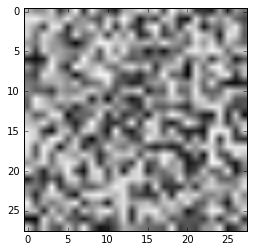

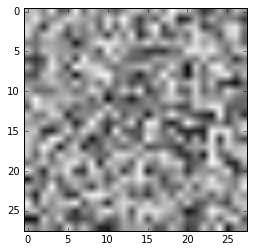

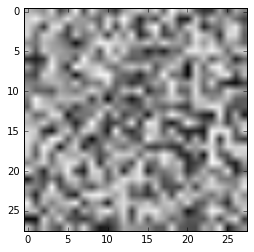

In [10]:
print("Untrained model...")
for t in range(len(cv)):
    c = cv[t][-1] # Last batch for each time step
    c_img = MNIST_row_as_image(c.tolist())
    plt.figure()
    plt.imshow(c_img, cmap = cm.Greys_r)

In [11]:
print("Training...")
print("Attention: %r" % attention)
losses_log = []
latent_losses_log = []

num_batches = 5000

for i in range(0,num_batches*batch_size,batch_size):
    imgs = mnist.train.images[i:i+batch_size][:]
    l, t_op, ll = sess.run([loss, train_op, loss_latent], feed_dict = {x:imgs})
    losses_log.append(l)
    latent_losses_log.append(ll)


Training...
Attention: False


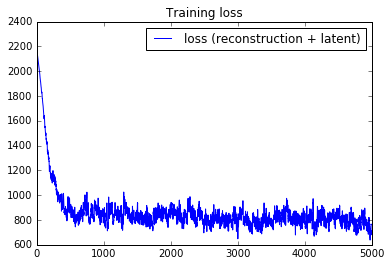

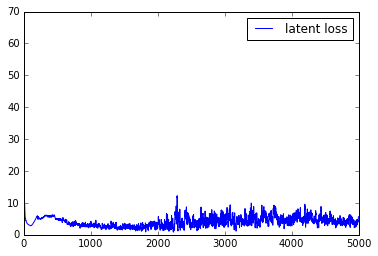

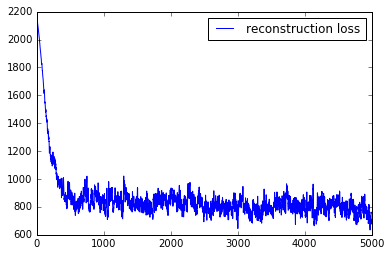

In [12]:
plt.figure()
plt.title("Training loss")

conv_size = 5
def smooth(ser):
    return np.convolve(ser, np.ones((conv_size,))/conv_size, mode='valid')

plt.plot(smooth(losses_log), label = "loss (reconstruction + latent)")
plt.legend()
plt.figure()
plt.plot(smooth(latent_losses_log), label = "latent loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(smooth([losses_log[k] - relative_weight*latent_losses_log[k] for k in range(len(losses_log))][:]), label = "reconstruction loss")
plt.legend()

plt.show()

Running...
821.8
[[[  2.17376545e-01   2.17561424e-01   2.18230143e-01 ...,   2.19199255e-01
     2.18406901e-01   2.18074366e-01]
  [  8.81361663e-02   8.55717212e-02   8.96243230e-02 ...,   8.85133967e-02
     8.38014558e-02   8.89964253e-02]
  [  1.08863473e-01   1.06458202e-01   1.10457659e-01 ...,   1.09685428e-01
     1.04959480e-01   1.09828688e-01]
  [  1.65069386e-01   1.63717419e-01   1.66536540e-01 ...,   1.66754037e-01
     1.63328707e-01   1.66065454e-01]]

 [[  5.10063544e-02   5.05079962e-02   5.21331728e-02 ...,   5.30617423e-02
     5.08892983e-02   5.18341959e-02]
  [  4.77599259e-03   4.38369717e-03   5.00891497e-03 ...,   4.83643264e-03
     4.12597833e-03   4.90856776e-03]
  [  7.38831237e-03   6.87471731e-03   7.72670470e-03 ...,   7.55613623e-03
     6.56266976e-03   7.58880284e-03]
  [  2.08774265e-02   2.00799219e-02   2.16238201e-02 ...,   2.16992870e-02
     1.97790097e-02   2.13654097e-02]]

 [[  7.82052334e-03   7.58088147e-03   8.22598115e-03 ...,   8.5336

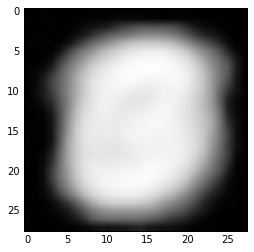

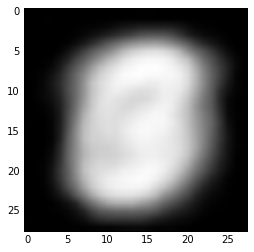

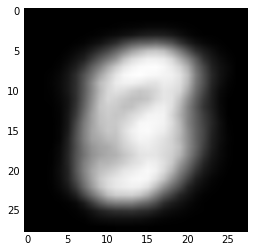

In [13]:
img1 = mnist.train.images[32171][:]
img2 = mnist.train.images[32170][:]
img3 = mnist.train.images[32169][:]
img4 = mnist.train.images[32168][:]

print("Running...")
l, cv, lmsout, lssout = sess.run([loss, canvas, lms, lss], feed_dict = {x:[img1, img2, img3, img4]})
print(l)
print(cv)

print("Trained model...")
for t in range(len(cv)):
    c = cv[t][-1] # Last batch for each time step
    c_img = MNIST_row_as_image(c.tolist())
    plt.figure()
    plt.imshow(c_img, cmap = cm.Greys_r)